In [1]:
!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib.pyplot as plt
import features as f
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.smoothers_lowess import lowess
import random

cheated_0 = Events('CheatedRecoFile_0.root')

  Using cached uproot-5.5.2-py3-none-any.whl.metadata (33 kB)
  Using cached awkward-2.7.4-py3-none-any.whl.metadata (7.0 kB)
  Using cached cramjam-2.9.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached awkward_cpp-44-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
Using cached uproot-5.5.2-py3-none-any.whl (363 kB)
Using cached awkward-2.7.4-py3-none-any.whl (871 kB)
Using cached awkward_cpp-44-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (638 kB)
Using cached cramjam-2.9.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.4 MB)


In [26]:
def primary(events, pdg_array, idx_array, pdg_set):
    mask = np.isin(pdg_array, list(pdg_set))
    test_idx = idx_array[mask]

    w_vtx = events.neutrino_vtx_w[test_idx]
    x_vtx = events.neutrino_vtx_x[test_idx]
    idx_w_vtx = events.reco_particle_vtx_w[test_idx]
    idx_x_vtx = events.reco_particle_vtx_x[test_idx]
    
    d_array = np.sqrt((w_vtx - idx_w_vtx)**2 + (x_vtx - idx_x_vtx)**2)
    closest_idx = test_idx[np.argmin(d_array)]

    vtx_proximity = np.sqrt((events.neutrino_vtx_w[closest_idx] - events.reco_particle_vtx_w[closest_idx])**2 
                           + (events.neutrino_vtx_x[closest_idx] - events.reco_particle_vtx_x[closest_idx])**2)

    if vtx_proximity < 1: # if the electron is primary
        return closest_idx
    else: return 'NCnu_x'

def largest_hits(events, idx_array):
    w_hits = events.reco_hits_w[idx_array]
    
    lengths = [len(hit_set) for hit_set in w_hits]
    
    return idx_array[np.argmax(lengths)]
    

def candidates(events, hits_cutoff=15):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1

    # Gets an array of unique events and their corresponding indices, example: [[1, 2, 3, 4], [5, 6, 7], ...]
    slices = np.split(np.arange(len(identifiers)), change_indices)

    # Transforms sliced array into pdg codes, example: [[2212, 22, 22, 22], [22, -11, 11], ...]
    pdgs = [events.mc_pdg[s] for s in slices]

    # some pdg codes
    muon = [-13, 13]
    electron = [-11, 11]
    
    candidate_dict = {
        'CCnu_e': [],
        'CCnu_mu': [],
    }

    # for truth and confusion testing
    candidate_list = []

    for event_number, (indices, pdg_vals) in enumerate(zip(slices, pdgs)):
        # Check for muons in the slice
        if np.isin(pdg_vals, muon).any():
            # If a muon is found, find primary muon
            muon_indices = indices[np.isin(pdg_vals, list(muon))]
            prim_mu = primary(events, pdg_vals, indices, muon)
            if prim_mu != 'NCnu_x':
                candidate_dict['CCnu_mu'].append(prim_mu)
            # Keep an ordered record of the candidates
            candidate_list.append(prim_mu)
        
        # Check for electrons in the slice
        elif np.isin(pdg_vals, electron).any():
            # If an electron is found, find the primary electron
            prim_e = primary(events, pdg_vals, indices, electron)
            if prim_e != 'NCnu_x':
                candidate_dict['CCnu_e'].append(prim_e)

            # Keep an ordered record of the candidates
            candidate_list.append(prim_e)
        
        else:
            # If neither muon nor primary electron is found
            candidate_list.append('NCnu_x')

    return candidate_dict, candidate_list

candidates_0 = candidates(cheated_0)[1]
print(f'{candidates_0[:50]}...\n')
print(f'{len(candidates_0)} candidates identified within the hits quality cut')

[1, 'NCnu_x', 108, 152, 161, 165, 260, 653, 655, 'NCnu_x', 685, 'NCnu_x', 819, 957, 1097, 1210, 'NCnu_x', 'NCnu_x', 'NCnu_x', 1554, 1562, 'NCnu_x', 2094, 'NCnu_x', 'NCnu_x', 2181, 2191, 2207, 2213, 'NCnu_x', 2539, 2588, 2616, 2706, 2717, 2803, 'NCnu_x', 2850, 2906, 2907, 2932, 3025, 3040, 3046, 3179, 3287, 3340, 'NCnu_x', 3466, 3531]...

8518 candidates identified within the hits quality cut


In [27]:
def true_category(events, hits_cutoff=15):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1

    # Takes first idx of each event, just for bool values.
    slices = [arr[0] for arr in np.split(np.arange(len(identifiers)), change_indices)]

    # Find boolean arrays for each CC
    CCnue_bool = events.is_nue[slices]
    CCnumu_bool = events.is_numu[slices]

    categories = np.zeros_like(slices, dtype=object)  # Change dtype to object to store strings

    for i in range(len(slices)):
        if CCnue_bool[i]:
            categories[i] = 'CCnu_e'
        elif CCnumu_bool[i]:
            categories[i] = 'CCnu_mu'
        else:
            categories[i] = 'NCnu_x'

    return categories

true_categories_0 = true_category(cheated_0)
print(f'{true_categories_0[:10]}...')

['CCnu_mu' 'NCnu_x' 'CCnu_mu' 'CCnu_mu' 'CCnu_mu' 'CCnu_mu' 'CCnu_mu'
 'NCnu_x' 'CCnu_mu' 'CCnu_mu']...


In [28]:
predicted_0 = np.zeros_like(candidates_0)

for i, j in enumerate(candidates_0):
    if j == 'NCnu_x':
        predicted_0[i] = 'NCnu_x'
    elif cheated_0.mc_pdg[j] in [-13, 13]:
        predicted_0[i] = 'CCnu_mu'
    elif cheated_0.mc_pdg[j] in [-11, 11]:
        predicted_0[i] = 'CCnu_e'

print(predicted_0[:10])

['CCnu_mu' 'NCnu_x' 'CCnu_mu' 'CCnu_mu' 'CCnu_mu' 'CCnu_mu' 'CCnu_mu'
 'CCnu_mu' 'CCnu_mu' 'NCnu_x']


In [29]:
# make a confusion matrix of truth vs precicted

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(true_categories_0, predicted_0, labels=['CCnu_e', 'CCnu_mu', 'NCnu_x'])

# Accuracy
TP = np.diagonal(cm).sum()
total_samples = cm.sum()
accuracy = TP / total_samples

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[r"CC ($\nu_e$)", r"CC ($\nu_\mu$)", r"NC ($\nu_x$)"], yticklabels=[r"CC ($\nu_e$)", r"CC ($\nu_\mu$)", r"NC ($\nu_x$)"])
plt.xlabel('------------------------Predicted------------------------')
plt.ylabel('------------------------True------------------------')
plt.title(f'Accuracy: {100 * accuracy:.2f}%')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [9505, 8518]

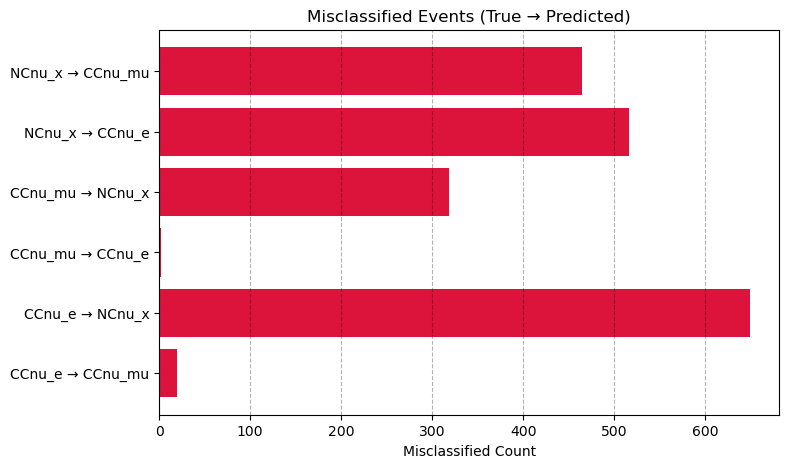

In [25]:
import pandas as pd

labels = ['CCnu_e', 'CCnu_mu', 'NCnu_x']
# Iterate over all the true and predicted labels
false_classifications = []
for true_idx, true_label in enumerate(labels):
    for pred_idx, pred_label in enumerate(labels):
        if true_idx != pred_idx:  # Only consider misclassifications
            # Get the indices where the prediction is wrong
            count = cm[true_idx, pred_idx]
            if count > 0:
                false_classifications.append((true_label, pred_label, count))

# Convert to a DataFrame for better readability
false_df = pd.DataFrame(false_classifications, columns=['True Label', 'Predicted Label', 'Count'])

# Ensure there are misclassifications before plotting
if not false_df.empty:
    plt.figure(figsize=(8, 5))
    plt.barh(false_df["True Label"] + " → " + false_df["Predicted Label"], false_df["Count"], color='crimson')
    plt.xlabel("Misclassified Count")
    plt.title("Misclassified Events (True → Predicted)")
    plt.grid(axis="x", linestyle="--", alpha=0.3, c='k')
    plt.show()
else:
    print("No misclassifications found!")


In [ ]:
misclassification_indices = {
    ('CCnu_e', 'CCnu_mu'): [],
    ('CCnu_e', 'NCnu_x'): [],
    ('CCnu_mu', 'CCnu_e'): [],
    ('CCnu_mu', 'NCnu_x'): [],
    ('NCnu_x', 'CCnu_e'): [],
    ('NCnu_x', 'CCnu_mu'): []
}

# Iterate over all the true and predicted categories
for idx, (true_category, predicted_category) in enumerate(zip(true_categories_0, predicted_0)):
    if true_category != predicted_category:  # Misclassification
        # Append the index to the corresponding list in the dictionary
        misclassification_indices[(true_category, predicted_category)].append(idx)

In [ ]:
''' Lets have a look at an NCnu_x -> CCnu_mu '''

example_idx = misclassification_indices[('NCnu_x', 'CCnu_mu')][32]

f.plot_idx_adc(cheated_0, example_idx)

In [ ]:
# AAAHHHHH we need to demand a quality cut again... or maybe not i dont know

# Find unique PDG codes
pdgs = np.unique(cheated_0.mc_pdg)

# create dictionary for PDGs
mc_pdg_dict = {
    -2212: "Anti proton",
    -321: "K-",
    -211: "π-",
    -13: "μ-",
    -11: "e- ",
    11: "e+",
    13: "μ+",
    22: "γ",
    211: "π+",
    321: "K+",
    2212: "proton",
    3112: "Σ-",
    3222: "Σ+",
    
    # Light Nuclei
    1000010020: "Deuteron",
    1000010030: "Triton",
    1000010040: "Helium-3",
    1000020030: "Helium-3 (alt)",
    1000020040: "Alpha Particle (He-4)",
    1000020060: "Helium-6",
    1000030060: "Lithium-6",
    1000030070: "Lithium-7",
    1000030080: "Lithium-8",
    1000040080: "Beryllium-8",
    1000040090: "Beryllium-9",
    1000040100: "Beryllium-10",
    1000070150: "Nitrogen-15",
    1000070160: "Nitrogen-16",
    1000070170: "Nitrogen-17",
    
    # Heavier Nuclei
    1000100200: "Neon-20",
    1000100220: "Neon-22",
    1000110230: "Sodium-23",
    1000120240: "Magnesium-24",
    1000120250: "Magnesium-25",
    1000120260: "Magnesium-26",
    1000120270: "Magnesium-27",
    1000120280: "Magnesium-28",
    1000130260: "Aluminum-26",
    1000130270: "Aluminum-27",
    1000130280: "Aluminum-28",
    1000130290: "Aluminum-29",
    1000140270: "Silicon-27",
    1000140280: "Silicon-28",
    1000140290: "Silicon-29",
    1000140300: "Silicon-30",
    1000140310: "Silicon-31",
    1000140320: "Silicon-32",
    1000140330: "Silicon-33",
    1000140340: "Silicon-34",
    1000150300: "Phosphorus-30",
    1000150310: "Phosphorus-31",
    1000150320: "Phosphorus-32",
    1000150330: "Phosphorus-33",
    1000150340: "Phosphorus-34",
    1000150350: "Phosphorus-35",
    1000150360: "Phosphorus-36",
    1000150370: "Phosphorus-37",
    1000160310: "Sulfur-31",
    1000160320: "Sulfur-32",
    1000160330: "Sulfur-33",
    1000160340: "Sulfur-34",
    1000160350: "Sulfur-35",
    1000160360: "Sulfur-36",
    1000160370: "Sulfur-37",
    1000160380: "Sulfur-38",
    1000160390: "Sulfur-39",
    1000170340: "Chlorine-34",
    1000170350: "Chlorine-35",
    1000170360: "Chlorine-36",
    1000170370: "Chlorine-37",
    1000170380: "Chlorine-38",
    1000170390: "Chlorine-39",
    1000170400: "Chlorine-40",
    1000180350: "Argon-35",
    1000180360: "Argon-36",
    1000180370: "Argon-37",
    1000180380: "Argon-38",
    1000180390: "Argon-39",
    1000180400: "Argon-40",
    1000180410: "Argon-41",
    1000190380: "Potassium-38",
    1000190390: "Potassium-39",
    1000190400: "Potassium-40",
    1000190410: "Potassium-41",
}



In [ ]:
def plot_event(events, event_number):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1
    event_indices = np.split(np.arange(len(identifiers)), change_indices)[event_number]

    w_hits = np.array(events.reco_hits_w[event_indices], dtype=object)
    x_hits = np.array(events.reco_hits_x_w[event_indices], dtype=object)
    event_pdgs = np.array(events.mc_pdg[event_indices])

    unique_pdgs = np.unique(event_pdgs)

    plt.figure(figsize=(12, 8))

    for pdg in unique_pdgs:
        mask = event_pdgs == pdg
        w = np.concatenate(w_hits[mask])
        x = np.concatenate(x_hits[mask])

        if len(w_hits[mask]) == 1:
            plt.scatter(w, x, s=3, label=mc_pdg_dict[pdg])
        else: plt.scatter(w, x, s=3, label=f'{mc_pdg_dict[pdg]} ({len(w_hits[mask])}x)')

    # Neutrino vertex
    w_vtx = events.neutrino_vtx_w[event_indices[0]]
    x_vtx = events.neutrino_vtx_x[event_indices[0]]

    classifier = 'NCnu_x'
    if events.is_nue[event_indices[0]]:
        classifier = 'CCnu_e'
    elif events.is_numu[event_indices[0]]:
        classifier = 'CCnu_mu'
    elif events.is_cc[event_indices[0]]:
        classifier = 'CC'

    plt.scatter(w_vtx, x_vtx, marker='*', facecolors='none', edgecolors='b', s=50, label='Neutrino Vertex')

    plt.title(f'W View for Event Number {event_number}. Event is a true {classifier}')
    plt.ylabel('x (cm)')
    plt.xlabel('w (cm)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# have a look at lots of mu as nc
for k in range(10):
    plot_event(cheated_0, misclassification_indices[('NCnu_x', 'CCnu_mu')][k])

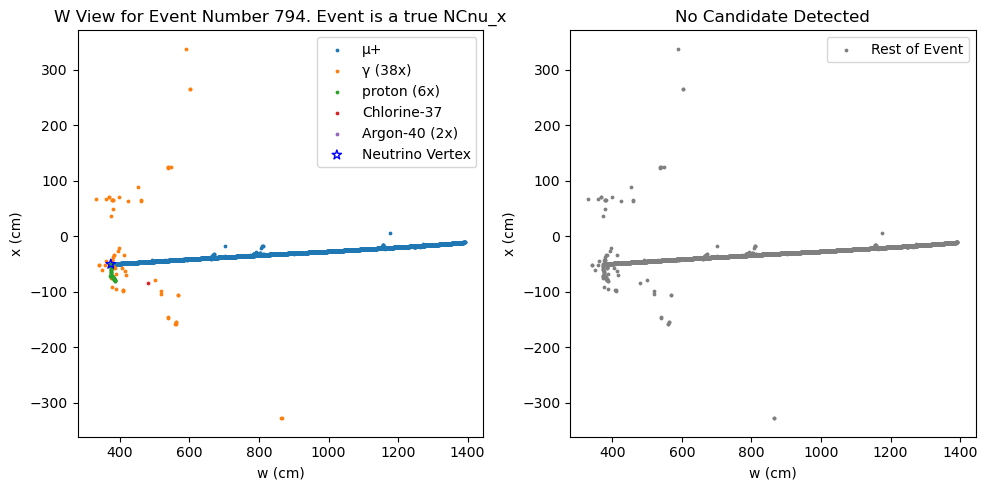

In [12]:
def CL_finder(events, event_number, show_plot=False, debug=False):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1

    # Gets an array of unique events and their corresponding indices, example: [[1, 2, 3, 4], [5, 6, 7], ...]
    slices = np.split(np.arange(len(identifiers)), change_indices)
    event_indices = slices[event_number]
    pdg_vals = events.mc_pdg[event_indices]

    # some pdg codes
    muon = [-13, 13]
    electron = [-11, 11]

    candidate_idx = None
    if np.isin(pdg_vals, muon).any():
        # If a muon is found, find muon with most hits
        muon_indices = event_indices[np.isin(pdg_vals, list(muon))]
        candidate_idx = largest_hits(events, muon_indices)
    
    # Check for electrons in the slice
    elif np.isin(pdg_vals, electron).any():
        # If an electron is found, find the primary electron
        prim = primary(events, pdg_vals, event_indices, electron)
        candidate_idx = prim
    
    else:
        candidate_idx = 'NCnu_x'

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    w_hits = np.array(events.reco_hits_w[event_indices], dtype=object)
    x_hits = np.array(events.reco_hits_x_w[event_indices], dtype=object)
    event_pdgs = np.array(events.mc_pdg[event_indices])

    unique_pdgs = np.unique(event_pdgs)

    for pdg in unique_pdgs:
        mask = event_pdgs == pdg
        w = np.concatenate(w_hits[mask])
        x = np.concatenate(x_hits[mask])

        if len(w_hits[mask]) == 1:
            ax[0].scatter(w, x, s=3, label=mc_pdg_dict[pdg])
        else: ax[0].scatter(w, x, s=3, label=f'{mc_pdg_dict[pdg]} ({len(w_hits[mask])}x)')

    # Neutrino vertex
    w_vtx = events.neutrino_vtx_w[event_indices[0]]
    x_vtx = events.neutrino_vtx_x[event_indices[0]]

    classifier = 'NCnu_x'
    if events.is_nue[event_indices[0]]:
        classifier = 'CCnu_e'
    elif events.is_numu[event_indices[0]]:
        classifier = 'CCnu_mu'
    elif events.is_cc[event_indices[0]]:
        classifier = 'CC'

    ax[0].scatter(w_vtx, x_vtx, marker='*', facecolors='none', edgecolors='b', s=50, label='Neutrino Vertex')

    ax[0].set_title(f'W View for Event Number {event_number}. Event is a true {classifier}')
    ax[0].set_ylabel('x (cm)')
    ax[0].set_xlabel('w (cm)')
    ax[0].legend()
    
    # Plot data on the second subplot
    ax[1].scatter(np.concatenate(w_hits), np.concatenate(x_hits), s=3, c='grey', label='Rest of Event')
    if isinstance(candidate_idx, int):
        ax[1].scatter(w_hits[candidate_idx], x_hits[candidate_idx], s=4, c='g', label=f'Candidate {event_pdgs[candidate_idx]}')
        ax[1].set_title('Candidate Plot')
    else: ax[1].set_title('No Candidate Detected')
    ax[1].set_ylabel('x (cm)')
    ax[1].set_xlabel('w (cm)')
    ax[1].legend()
    
    # Show the figure
    plt.tight_layout()
    plt.show()

CL_finder(cheated_0, misclassification_indices[('NCnu_x', 'CCnu_mu')][81], show_plot=True)

In [13]:
# trying a bdt for candidate leptons

''' Features for CL filtering '''

def pdg(events, event_idx):
    return events.mc_pdg[event_idx]

def hit_count(events, event_idx):
    return events.reco_hits_w[event_idx]

def adc_sum(events, event_idx):
    return np.sum(events.reco_adcs_w[event_idx])

def charged_lepton(events, event_idx):
    if events.is_numu[event_idx]:
        return 1
    elif events.is_nue[event_idx]:
        return 2
    else: return 0

# Get the event slices manually now
cheated_0 = Events('CheatedRecoFile_0.root')
cheated_5 = Events('CheatedRecoFile_5.root')

identifiers_0 = cheated_0.event_number
change_indices_0 = np.where(np.diff(identifiers_0) != 0)[0] + 1
slices_0 = np.split(np.arange(len(identifiers_0)), change_indices_0) # Cheated_0 events

identifiers_5 = cheated_5.event_number
change_indices_5 = np.where(np.diff(identifiers_5) != 0)[0] + 1
slices_5 = np.split(np.arange(len(identifiers_5)), change_indices_5) # Cheated_5 events

def calculate_features(events, indices):
    features = {
        'pdg': [],
        'hit_count': [],
        'adc_sum': [],
        'charged_lepton': []
    }

    for event_idx in indices:
        features['pdg'].append(pdg(events, event_idx))
        features['hit_count'].append(hit_count(events, event_idx))
        features['adc_sum'].append(adc_sum(events, event_idx))
        features['charged_lepton'].append(charged_lepton(events, event_idx))
    return features